In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing

In [3]:
# Load train data

fraud_data = pd.read_csv('data/imbalancedFraudDF.csv')
ip_country_ref = pd.read_csv('data/IpAddress_to_Country.csv')

fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


In [4]:
# Show the distribution of labels
# Find data is highly imbalanced

row_num = fraud_data.shape[0]
fraud_rate = fraud_data['class'].value_counts() / row_num


In [5]:
fraud_rate

class
0    0.989774
1    0.010226
Name: count, dtype: float64

In [8]:
# Identify contry from ip address

ip_country_ref.head()

countries = []
for i  in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']

    tmp = ip_country_ref[(ip_address >= ip_country_ref['lower_bound_ip_address']) &
                         (ip_address <= ip_country_ref['upper_bound_ip_address'])]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')

fraud_data['county'] = countries




In [9]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,county
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


In [19]:
# Extract hours from signup_time and purchase_time

fraud_data['signup_timestamp'] = pd.to_datetime(fraud_data['signup_time'])

fraud_data['purchase_timestamp'] = pd.to_datetime(fraud_data['purchase_time'])

fraud_data['signup_hour'] = fraud_data['signup_timestamp'].dt.hour

fraud_data['purchase_hour'] = fraud_data['purchase_timestamp'].dt.hour

fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,county,signup_timestamp,purchase_timestamp,signup_hour,purchase_hour
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,2015-02-24 22:55:49,2015-04-18 02:47:11,22,2
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,2015-06-07 20:39:50,2015-06-08 01:38:54,20,1
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,2015-04-28 21:13:25,2015-05-04 13:54:50,21,13
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,2015-07-21 07:09:52,2015-09-09 18:40:53,7,18
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,2015-05-21 06:03:03,2015-07-09 08:05:14,6,8


Text(0, 0.5, 'Number of Sign-ups')

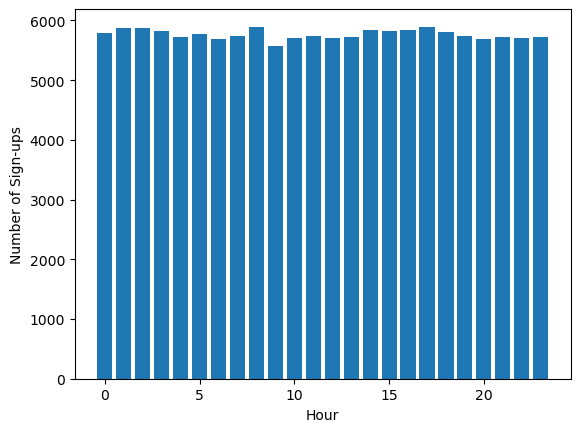

In [25]:
# Sign-ups were evenly distributed across hours

signup_by_hour = fraud_data.groupby('signup_hour').size().reset_index(name = 'count')

plt.bar(signup_by_hour['signup_hour'], signup_by_hour['count'])

plt.xlabel('Hour')
plt.ylabel('Number of Sign-ups')


Text(0, 0.5, 'Number of Purchases')

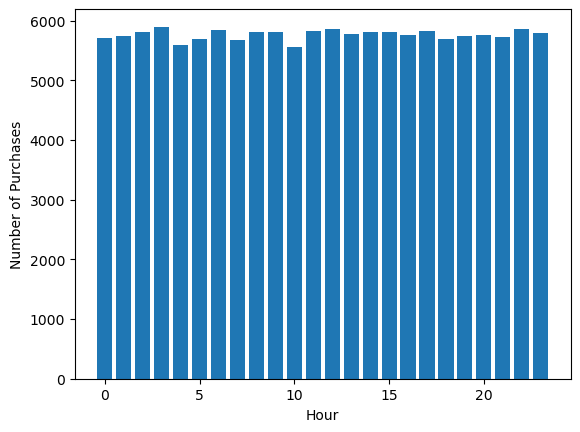

In [27]:
purchase_by_hour = fraud_data.groupby('purchase_hour').size().reset_index(name = 'count')

plt.bar(purchase_by_hour['purchase_hour'], purchase_by_hour['count'])

plt.xlabel('Hour')
plt.ylabel('Number of Purchases')

(array([1.1041e+04, 1.2713e+04, 1.3686e+04, 1.4622e+04, 1.4120e+04,
        1.3635e+04, 1.2580e+04, 1.0977e+04, 9.3290e+03, 7.3320e+03,
        5.8110e+03, 4.2050e+03, 3.0650e+03, 2.0070e+03, 1.3500e+03,
        7.9700e+02, 4.8400e+02, 2.7200e+02, 1.6900e+02, 1.0100e+02,
        4.3000e+01, 1.7000e+01, 7.0000e+00, 8.0000e+00, 3.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  9.,  14.,  19.,  24.,  29.,  34.,  39.,  44.,  49.,  54.,  59.,
         64.,  69.,  74.,  79.,  84.,  89.,  94.,  99., 104., 109., 114.,
        119., 124., 129., 134., 139., 144., 149., 154.]),
 <BarContainer object of 29 artists>)

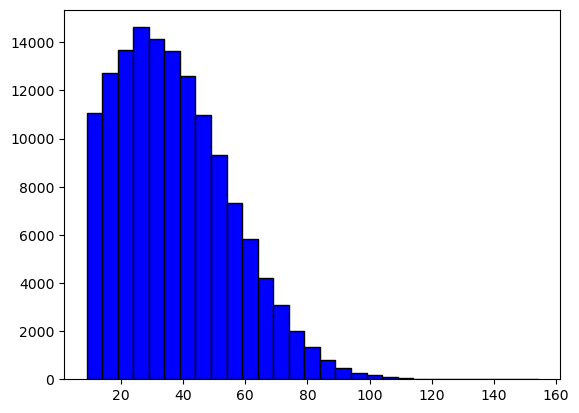

In [32]:
# Plot distribution of purchase values

fraud_data['purchase_value'].describe()

plt.hist(fraud_data['purchase_value'], color = 'blue', edgecolor = 'black',
         bins = int((fraud_data['purchase_value'].max() - fraud_data['purchase_value'].min()) / 5))
